In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import *

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import models, layers, regularizers

C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
!nvidia-smi 

Mon Jan 30 01:50:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()

In [2]:
#Set Parameters
im_width = 256
im_height = 256


# **Load image's path and mask's path**

In [6]:
train_files = []
mask_files = glob('./input_data/*/*_mask*')

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

['./input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_14.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_15.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_16.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_17.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_18.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_19.tif']
['./input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_10_mask.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_11_mask.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_12_mask.tif', './input_data\\TCGA_CS_4941_19960909\\TCGA_CS_4941_19960909_13_mask.tif', './input_dat

# **Data Visualization**

In [3]:
#Lets plot some samples
ds = dicom.dcmread(image_path)
pixel_array_numpy = ds.pixel_array

rows,cols=3,3
fig=plt.figure(figsize=(10,10))
for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_path=train_files[i]
    msk_path=mask_files[i]
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    msk=cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk,alpha=0.4)
plt.show()

KeyboardInterrupt: 

# **Create data frame and split data on train set, validation set and test set**

In [7]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.15)
df_train, df_val = train_test_split(df_train,test_size = 0.1765)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2749, 2)
(590, 2)
(590, 2)


# **Data genertator, data augmentation and adjust data**

In [8]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)
    
    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    
    return (img, mask)

# **Define loss function and metrics**

In [10]:
smooth=100
import keras.backend as K
# from sklearn.metrics import sensitive_score, specificity_score
# specificity = specificity_score(y_test, y_pred)
# sensitive = sensitive_score(y_test, y_pred)

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

# def specificity(y_true: np.array, y_pred: np.array, classes: set = None):

#     if classes is None: # Determine classes from the values
#         classes = set(np.concatenate((np.unique(y_true), np.unique(y_pred))))

#     specs = []
#     for cls in classes:
#         y_true_cls = (y_true == cls).astype(int)
#         y_pred_cls = (y_pred == cls).astype(int)

#         fp = sum(y_pred_cls[y_true_cls != 1])
#         tn = sum(y_pred_cls[y_true_cls == 0] == False)

#         specificity_val = tn / (tn + fp)
#         specs.append(specificity_val)

#     return np.mean(specs)

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

ALPHA = 0.5
BETA = 0.5

def Tversky(y_true, y_pred, alpha=ALPHA, beta=BETA, smooth=100):
        
        #flatten label and prediction tensors
        y_pred = K.flatten(y_pred)
        y_true = K.flatten(y_true)
        
        #True Positives, False Positives & False Negatives
        TP = K.sum((y_pred * y_true))
        FP = K.sum(((1-y_true) * y_pred))
        FN = K.sum((y_true * (1-y_pred)))
       
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
        
        return Tversky

# **Unet Plus Plus**

In [30]:
from keras import backend as K
from keras.layers import concatenate, Conv2DTranspose, Activation
from keras.layers import BatchNormalization


from keras.layers import Conv2D, Input, AvgPool2D
from keras.models import Model

dropout_rate = 0.5

def conv_batchnorm_relu_block(input_tensor, nb_filter, kernel_size=3):

    x = Conv2D(nb_filter, (kernel_size, kernel_size), padding='same')(input_tensor)
    x = BatchNormalization(axis=2)(x)
    x = Activation('relu')(x)

    return x


def unet_plus(input_shape=(256,256,3), n_labels=1, using_deep_supervision=False):

    nb_filter = [32,64,128,256,512]

    # Set image data format to channels first
    global bn_axis

    K.set_image_data_format("channels_last")
    bn_axis = -1
    inputs = Input(shape=input_shape, name='input_image')

    conv1_1 = conv_batchnorm_relu_block(inputs, nb_filter=nb_filter[0])
    pool1 = AvgPool2D((2, 2), strides=(2, 2), name='pool1')(conv1_1)

    conv2_1 = conv_batchnorm_relu_block(pool1, nb_filter=nb_filter[1])
    pool2 = AvgPool2D((2, 2), strides=(2, 2), name='pool2')(conv2_1)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], name='merge12', axis=bn_axis)
    conv1_2 = conv_batchnorm_relu_block(conv1_2,  nb_filter=nb_filter[0])

    conv3_1 = conv_batchnorm_relu_block(pool2, nb_filter=nb_filter[2])
    pool3 = AvgPool2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], name='merge22', axis=bn_axis)
    conv2_2 = conv_batchnorm_relu_block(conv2_2, nb_filter=nb_filter[1])

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], name='merge13', axis=bn_axis)
    conv1_3 = conv_batchnorm_relu_block(conv1_3, nb_filter=nb_filter[0])

    conv4_1 = conv_batchnorm_relu_block(pool3, nb_filter=nb_filter[3])
    pool4 = AvgPool2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=bn_axis)
    conv3_2 = conv_batchnorm_relu_block(conv3_2, nb_filter=nb_filter[2])

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], name='merge23', axis=bn_axis)
    conv2_3 = conv_batchnorm_relu_block(conv2_3, nb_filter=nb_filter[1])

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], name='merge14', axis=bn_axis)
    conv1_4 = conv_batchnorm_relu_block(conv1_4, nb_filter=nb_filter[0])

    conv5_1 = conv_batchnorm_relu_block(pool4, nb_filter=nb_filter[4])

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=bn_axis)
    conv4_2 = conv_batchnorm_relu_block(conv4_2, nb_filter=nb_filter[3])

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=bn_axis)
    conv3_3 = conv_batchnorm_relu_block(conv3_3, nb_filter=nb_filter[2])

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], name='merge24', axis=bn_axis)
    conv2_4 = conv_batchnorm_relu_block(conv2_4, nb_filter=nb_filter[1])

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], name='merge15', axis=bn_axis)
    conv1_5 = conv_batchnorm_relu_block(conv1_5, nb_filter=nb_filter[0])

    nestnet_output_1 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_1',padding='same')(conv1_2)
    nestnet_output_2 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_2', padding='same' )(conv1_3)
    nestnet_output_3 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_3', padding='same')(conv1_4)
    nestnet_output_4 = Conv2D(n_labels, (1, 1), activation='sigmoid', name='output_4', padding='same')(conv1_5)

    if using_deep_supervision:
        model = Model(input=inputs, output=[nestnet_output_1,
                                            nestnet_output_2,
                                            nestnet_output_3,
                                            nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=nestnet_output_4)

    return model

# **Define Attention Unet**

In [10]:
def att_unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [11]:
model = att_unet()
# model.summary()

2023-01-30 14:36:58.708923: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 14:36:58.845582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 14:36:58.846416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-30 14:36:58.847570: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

# **Training**

In [31]:
# EPOCHS = 30
# BATCH_SIZE = 16
# learning_rate = 1e-4

EPOCHS = 100
BATCH_SIZE = 32
learning_rate = 1e-4
model = unet_plus()

In [ ]:
len(df_val)/BATCH_SIZE

In [32]:
im_height, im_width = 256,256
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
    
# model = Attention_UNet(input_shape=(im_height, im_width, 3))
#callbacks
earlystopping = EarlyStopping(monitor='val_dice_coef',
                              mode='max', 
                              verbose=1, 
                              patience=20
                             )
# save the best model with lower validation loss

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coef',
                              mode='max',
                              verbose=1,
                              patience=10,
                              min_delta=0.0001,
                              factor=0.2
                             )


decay_rate = learning_rate / EPOCHS
opt = Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt, loss=dice_coef_loss, metrics=[iou, dice_coef, precision,recall,specificity])

callbacks = [ModelCheckpoint('best_model.hdf5',monitor='val_dice_coef', verbose=1, mode='max',save_best_only=True)]

history = model.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2749 validated image filenames.
Found 2749 validated image filenames.


2023-01-31 02:36:58.219759: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2023-01-31 02:37:04.200389: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-31 02:37:11.742058: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


86/85 [==============================] - ETA: 0s - loss: -0.1896 - iou: 0.1096 - dice_coef: 0.1898 - precision: 0.3443 - recall: 0.6802 - specificity: 0.9136Found 590 validated image filenames.
Found 590 validated image filenames.
85/85 [==============================] - 123s 1s/step - loss: -0.1896 - iou: 0.1096 - dice_coef: 0.1898 - precision: 0.3443 - recall: 0.6802 - specificity: 0.9136 - val_loss: -0.0229 - val_iou: 0.0117 - val_dice_coef: 0.0227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_specificity: 1.0000

Epoch 00001: val_dice_coef improved from -inf to 0.02266, saving model to best_model.hdf5
Epoch 2/100
85/85 [==============================] - 80s 933ms/step - loss: -0.3445 - iou: 0.2125 - dice_coef: 0.3443 - precision: 0.5819 - recall: 0.6784 - specificity: 0.9940 - val_loss: -0.0163 - val_iou: 0.0089 - val_dice_coef: 0.0163 - val_precision: 0.0526 - val_recall: 1.6339e-06 - val_specificity: 1.0000

Epoch 00002: val_dice_coef did not improve from 0.02266
Epo

In [37]:
import pandas as pd
pd.DataFrame.from_dict(history.history).to_csv('history.csv',index=False)

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_trainloss,'r-')
plt.plot(list_testloss, 'b-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)

plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)

plt.figure(3)
plt.plot(list_trainjaccard,'r-')
plt.plot(list_testjaccard, 'b-')
plt.xlabel('epoch')
plt.ylabel('IoU')
plt.title('IoU graph', fontsize = 15)

plt.show()

In [13]:
model = load_model('../att_unet/2/best_model.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef, 'precision': precision,'recall':recall, 'specificity':specificity })

In [35]:
test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

val_gen = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

results_train = model.evaluate(train_gen, steps=len(df_train) / BATCH_SIZE)
results_test = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
results_val = model.evaluate(val_gen, steps=len(df_val) / BATCH_SIZE)

result = pd.DataFrame({  'train':({'loss':results_train[0],'iou':results_train[1],'dice_coef':results_train[2],'precision':results_train[3],'recall':results_train[4],'specificity':results_train[5]}),
                         'test':({'loss':results_test[0],'iou':results_test[1],'dice_coef':results_test[2],'precision':results_test[3],'recall':results_test[4],'specificity':results_test[5]}),
                         'val':({'loss':results_val[0],'iou':results_val[1],'dice_coef':results_val[2],'precision':results_val[3],'recall':results_val[4],'specificity':results_val[5]}) })

pd.DataFrame.from_dict(result).to_csv('result.csv',index=False)

85/85 [==============================] - 62s 713ms/step - loss: -0.9065 - iou: 0.8313 - dice_coef: 0.9064 - precision: 0.9134 - recall: 0.9036 - specificity: 0.9992
Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 7s 365ms/step - loss: -0.8858 - iou: 0.7919 - dice_coef: 0.8826 - precision: 0.8951 - recall: 0.8737 - specificity: 0.9988
Found 590 validated image filenames.
Found 590 validated image filenames.
18/18 [==============================] - 4s 204ms/step - loss: -0.8710 - iou: 0.7728 - dice_coef: 0.8705 - precision: 0.8810 - recall: 0.8648 - specificity: 0.9988


In [36]:
result

,train,test,val
loss,-0.906478,-0.885793,-0.870997
iou,0.831287,0.791949,0.772816
dice_coef,0.906411,0.882562,0.870486
precision,0.913384,0.895069,0.881036
recall,0.903592,0.873721,0.864781
specificity,0.999178,0.998849,0.998797


1/1 [==============================] - 0s 427ms/step


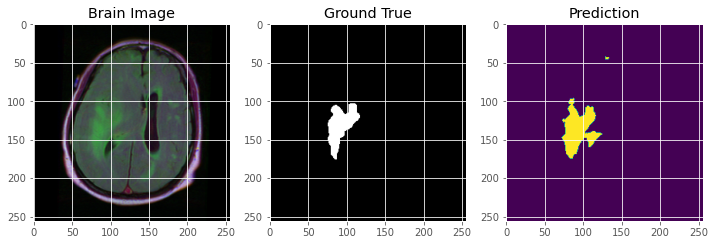

In [23]:
for i in range(1,2):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(i,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Brain Image')
    plt.subplot(i,3,2)
    plt.imshow(np.squeeze(cv2.imread(df['mask'].iloc[index])))
    plt.title('Ground True')
    plt.subplot(i,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')


# plt.show()
plt.savefig('image.png')

In [ ]:
def diagnosis(mask_path):
    value = np.max(cv2.imread(mask_path))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image_path": train_files,
                   "mask_path": mask_files,
                  "diagnosis":[diagnosis(x) for x in mask_files]})
df.head()

In [ ]:
ax = df['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.15)
df_train, df_val = train_test_split(df_train, test_size=0.1765)

In [ ]:
ax = df_train['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df_train['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [ ]:
ax = df_val['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df_val['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)

In [ ]:
ax = df_test['diagnosis'].value_counts().plot(kind='bar', stacked=True, figsize=(10,6), color=['blue', 'red'])
ax.set_title('Data Distribution')
ax.set_ylabel('Total Images', fontsize=15)
ax.set_xticklabels(['No Tumor', 'Tumor'], fontsize=12, rotation=0)
for i, rows in enumerate(df_test['diagnosis'].value_counts().values):
    ax.annotate(int(rows), xy=(i, rows+12), ha='center', fontweight='bold', fontsize=15)